# MIDAS COMPUTER VISION TASK
The following notebook contains the solution to solution to MIDAS's Computer Vision task for summer internship 2019.We need to build a Machine Learning Classifer to classify images.The notebook is divided into many parts.
<ol>
    <li>Loading Data,Preprocessing</li>
    <li>Dataset Description</li>
    <li>Building the Model</li>
    <li>Model Evaluation</li>
    </ol>

## 1.DATA LOADING AND PREPROCESSING
Initially we load the pickle file and import all dependencies for the project.In order to simplify numerical computations we convert all lists to numpy arrays.

In [1]:
import numpy as np
import torch
from torch import nn as nn
import matplotlib.pyplot as plt
import pickle 
import time
import torch.nn.functional as T

In [2]:
with open('Vision_task_dataset_public/train_image.pkl','rb') as f:
    train_images =pickle.load(f)
with open('Vision_task_dataset_public/test_image.pkl','rb') as f:
    test_images =pickle.load(f)
with open('Vision_task_dataset_public/train_label.pkl','rb') as f:
    train_label =pickle.load(f)
train_images,train_label,test_images = np.asarray(train_images),np.asarray(train_label),np.asarray(test_images)

# RESHAPE DATASET TO A 2D IMAGES
train_images = train_images.reshape(-1,28,28)
test_images = test_images.reshape(-1,28,28)

Let us examine all the different classes in our train labels and see how many classes there are.

In [3]:
np.unique(train_label)

array([0, 2, 3, 6])

We can clearly see that the labels are 0,2,3 and 6.We need these function to continuous range of values so that it becomes easy to train our neural network.We define a function for mapping and inverse mapping.

In [4]:
#Map
def Map(y,reverse=False):
    mapper = [0,2,3,6]
    if reverse:
        inverse_mapper = [mapper[s] for s in y]
        return inverse_mapper
    mapped_labels = [mapper.index(s) for s in y]
    return mapped_labels

train_label = Map(train_label)

### Splitting
In order to evaluate our model we create a validation and training dataset.We train our model on the training dataset and then evaluate on the validation dataset.We then finetune our hyperparameters accordingly to suit our validation dataset.We take the split ration as 70-30(Train-Val).

In [5]:
def train_test_split(X,y,split_ratio = 0.2):
    X,y = np.array(X),np.array(y)
    len_data = X.shape[0]
    indices = np.arange(len_data)
    np.random.shuffle(indices)
    train_indices,val_indices = indices[:int((1-split_ratio)*len_data)],indices[int((1-split_ratio)*len_data):]
    X_train,y_train = X[train_indices],y[train_indices]
    X_val,y_val = X[val_indices],y[val_indices]
    return X_train,X_val,y_train,y_val 

################## TRAIN-TEST-SPLIT #########################
X_train,X_val,y_train,y_val = train_test_split(train_images,train_label,0.2)
print("Train Dataset size is",format(X_train.shape[0]))
print("Test Dataset size is",format(X_val.shape[0]))


Train Dataset size is 6400
Test Dataset size is 1600


## 2.DATASET DESCRIPTION
In order to create a good model we need to have a look at the type of dataset.The dataset consists of 8000 images of 28 * 28 pixels each.The images are one channel images i.e. grayscale images.

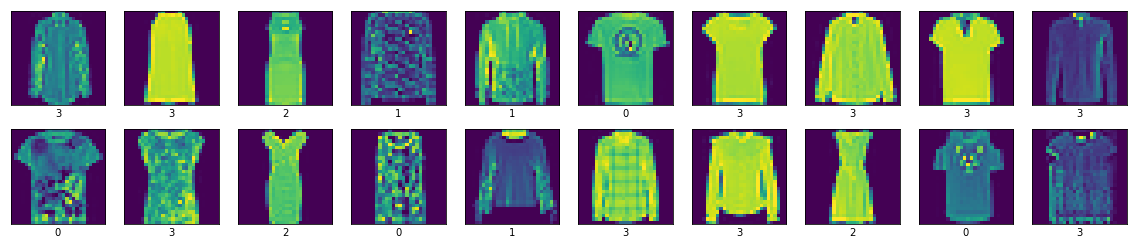

In [6]:
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in range(20):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    plt.imshow(X_train[idx])
    plt.xlabel(y_train[idx])

We can clearly see that the dataset consists of Clothes and is a subset of the MNIST Fashion Dataset.The labels signify the following.
<ol>
    <li> 0 -> T-SHIRT </li>    
    <li> 1 -> DRESS </li>  
    <li> 2 -> COAT </li>  
    <li> 3 -> SHIRT </li>  
</ol>

## 3.BUILDING THE MODEL
The Dataset consists of primarily images thus I have decided to use a Convolutional Neural Network to classify my images.CNNs were first introduced by Yann LeCun and showed great promise in classifying handwritten digits on postal cards.In 2012,they helped in spurring the Deep Learning Revolution when Hinton and his team used CNN to <a href="https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf"> classify images in the Imagenet data</a> and achieved record accuracy rate. 

My model is of the format

<b>[[CONV_LAYER -> 2D BATCH NORM -> RELU -> MAXPOOL -> DROPOUT] * 3 -> DROPOUT -> FULLY CONNECTED LAYER]</b>


In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        
        #first layer recieves 1*28*28 Image
        self.conv1=nn.Conv2d(1,16,kernel_size = 5, padding = 2,stride = 1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        
        # Maxpooling layers with square kernel size of 2
        self.pool=nn.MaxPool2d(2,2)
        
        #second layer recieves 16*14*14 Image
        self.conv2=nn.Conv2d(16,32,kernel_size = 5,padding = 2,stride = 1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        
        #third layer recieves 32*7*7 Image
        self.conv3=nn.Conv2d(32,64,kernel_size = 5,padding = 2,stride = 1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        
        #fourth layer recieves 64*3*3 Image flattened so a 576 Dimensional vector
        self.fc2=nn.Linear(576,4)
        
        #dropout to decrease 
        self.dropout = nn.Dropout(p=0.2)
     
    def forward(self,x):
        op2 = self.pool(T.relu(self.batch_norm1(self.conv1(x))))
        op2 = self.dropout(op2)
        op2 = self.pool(T.relu(self.batch_norm2(self.conv2(op2))))
        op2 = self.dropout(op2)
        op2 = self.pool(T.relu(self.batch_norm3(self.conv3(op2))))
        op2 = op2.view(-1,576)
        op2 = self.dropout(op2)
        op2 = self.fc2(op2)
        return op2

# INSTANTIATE PYTORCH MODEL
model = Model()

After applying all the layer in the inner bracket 3 times in succession we flatten the image and pass it through a fully connected layer to predict probabilities of each class.

In order for our Pytorch Model to process the incoming image we need to convert it into a Pytorch Float Tensor.

In [8]:
def convert_image_tensor(X,dim):
    X = X.reshape(-1,1,dim,dim)
    X = torch.from_numpy(X)
    return X
X_train,X_val = convert_image_tensor(X_train,28).float(),convert_image_tensor(X_val,28).float()
y_train,y_val = torch.from_numpy(y_train),torch.from_numpy(y_val)

Now we need to define certain hyperparameters to train the network.We use a batch_size of 32 and a learning rate of 0.01.We use an Adam optimizer to speed up gradient descent. For a loss criterion I have use Multi Class Cross Entropy along with the Adam optimizer.I also use a scheduler to change the learning rate whenever the training of the model stagnates.

In [9]:
batch_size = 32
learning_rate = 0.01
epochs = 36

############## DO NOT CHANGE #########################################
num_batches = int(X_train.shape[0]/batch_size)

#Criterion of Loss
criterion = nn.CrossEntropyLoss()     

#Optimizer helps in increasing speed of Gradient Descent.We are using Adam
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# A scheduler helps in scheduling the learning rate so that when cost function increases due to a large learning rate
# It decreases the learning rate by 90% if there is no change or increase in the accuracy for 5 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,patience = 5)

Let us also define a helper function to check the accurcy of model during the training loop after every epoch.

In [10]:
def model_accuracy(model,X,y):
    pred=model(X.float())
    total=0
    correct=0
    _, predicted = torch.max(pred.data, 1)
    total += y.size(0)
    correct += (predicted == y.long()).sum().item()
    return (correct/total)*100


## 3.TRAINING THE MODEL
Now that we have built the model it is necessary for us to train it.

In [11]:
def train_model(model,criterion,optimizer,checkpt_file,X_train,y_train,X_val,y_val,num_batches,batch_size,epochs):
    
    max_accuracy = 0
    accuracies = []
    for epoch in range(epochs):
        
        #Set model in train phase so that Dropouts are activated
        model.train()
        first_time = time.time()
        total_loss = 0
        
        for curr_batch in range(num_batches):
            
            # Clear all previous gradients so that they do not mixed up during batch training
            model.zero_grad()
               
            # Batch the data
            X_temp = X_train [ curr_batch*batch_size : (curr_batch+1)*batch_size ]
            y_temp = y_train [ curr_batch*batch_size : (curr_batch+1)*batch_size ]
            
            #BREAK LOOP IF TRAINING HAS ENDED
            if X_temp.shape[0]==0:
                break
                
            
            labels = model(X_temp)                #make prediction
            loss = criterion(labels,y_temp)       #calculate loss
            total_loss += loss.item()             #Calculate total loss
            loss.backward()                       #Backpropagate
            optimizer.step()                      #APPLY ADAM AND CHANGE GRADIENTS
        
        #Set model in evaluation phase so that Dropouts and Batch Norm is switched off
        model.eval()
        print("Epoch::",epoch+1)
        print("Training Loss after epoch",epoch+1,"is ",format(total_loss/num_batches))
        print("Training model accuracy is ",model_accuracy(model,X_train,y_train))
        print("Test model accuracy is ",model_accuracy(model,X_val,y_val))
        print("Time taken is",time.time()-first_time)
        
        #PRINT LEARNING RATE
        for param_group in optimizer.param_groups:
            print("Current learning rate is: {}".format(param_group['lr']))
        
        val_acc = model_accuracy(model,X_val,y_val)
        
        #SAVE MODEL IF ACCURACY INCREASES  
        if val_acc > max_accuracy :
            print('Validation accuracy has increased from ({:.6f} --> {:.6f}).  Saving model ...'.format(max_accuracy,val_acc))
            torch.save(model.state_dict(), checkpt_file)
            max_accuracy = val_acc 
        
        print("_____________________________________________________________________________________________")
       
        #Decrease learning rate if validation accuracy stagnates or increases at some point of time.
        learning_rate = param_group['lr']
        if learning_rate > 0.0001:
            scheduler.step(model_accuracy(model,X_val,y_val))
            
        accuracies.append((model_accuracy(model,X_train,y_train),val_acc))    
    return accuracies
        
accuracies = train_model(model,criterion,optimizer,"clothes_1_2.pt",X_train,y_train,X_val,y_val,num_batches,batch_size,epochs)    

Epoch:: 1
Training Loss after epoch 1 is  0.7002204252779484
Training model accuracy is  80.25
Test model accuracy is  80.4375
Time taken is 19.003968000411987
Current learning rate is: 0.01
Validation accuracy has increased from (0.000000 --> 80.437500).  Saving model ...
_____________________________________________________________________________________________
Epoch:: 2
Training Loss after epoch 2 is  0.5164098178595304
Training model accuracy is  83.5
Test model accuracy is  81.0
Time taken is 20.65911602973938
Current learning rate is: 0.01
Validation accuracy has increased from (80.437500 --> 81.000000).  Saving model ...
_____________________________________________________________________________________________
Epoch:: 3
Training Loss after epoch 3 is  0.4609703271090984
Training model accuracy is  85.078125
Test model accuracy is  84.1875
Time taken is 17.022216081619263
Current learning rate is: 0.01
Validation accuracy has increased from (81.000000 --> 84.187500).  Saving

Validation accuracy has increased from (88.500000 --> 88.625000).  Saving model ...
_____________________________________________________________________________________________
Epoch:: 26
Training Loss after epoch 26 is  0.242832324039191
Training model accuracy is  93.296875
Test model accuracy is  88.4375
Time taken is 15.323692083358765
Current learning rate is: 0.0001
_____________________________________________________________________________________________
Epoch:: 27
Training Loss after epoch 27 is  0.23614041799679397
Training model accuracy is  93.40625
Test model accuracy is  88.5625
Time taken is 15.3593909740448
Current learning rate is: 0.0001
_____________________________________________________________________________________________
Epoch:: 28
Training Loss after epoch 28 is  0.23561265906319023
Training model accuracy is  93.453125
Test model accuracy is  88.5625
Time taken is 19.17014503479004
Current learning rate is: 0.0001
________________________________________

### MODEL EVALUATION
Now that we have trained our model we need to evaluate and draw certain conclusions to evaluate and improve the model.First let us observe the training and validation losses at each epoch using a graph.

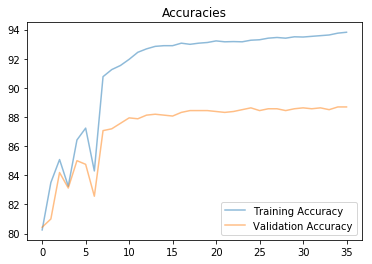

In [13]:
######## EXTRACT VAL AAND TRAIN ACCURACY ############
val_accs = [acc[1] for acc in accuracies]
train_accs = [acc[0] for acc in accuracies]

######## CREATE PLOT ###############
fig, ax = plt.subplots()
plt.plot(train_accs, label='Training Accuracy', alpha=0.5)
plt.plot(val_accs, label='Validation Accuracy', alpha=0.5)
plt.title("Accuracies")
plt.legend()

### CONCLUSIONS
<ol>
    <li><b>Overfitting</b>
    The Model is prone to moderate overfitting because of the large difference in training and validation accuracy to the end of the training.
 </li>
    <li><b>High Variance</b>
    The Model has a little bit variance  as it is prone to overfitting/
 </li> 
 </ol>
 
### TIPS TO INCREASE ACCURACY
<ol>
    <li><b>Adding Regularization</b>
    In order to decrease the difference between validation and training accuracy we might add regularization to the network to decrease variance and improve the model.
 </li>
    <li><b>Collecting more data</b>
    Adding more data can definitely decrease variance and let the model learn over a larger sample space.Better Machine Learning Models use 100 times the data that we have used to build or model.
 </li>
 </ol>
 
## MODEL TESTING
Now that we have analyzed our model properly we need to load the model and  calculate its F1 Score to see how it works .Finally,we evaluate our model on the given test set.
    

In [14]:
from sklearn.metrics import f1_score,classification_report
def F1_Score(model,X,y):
    pred=model(X.float())
    _, predicted = torch.max(pred.data, 1) 
    print(classification_report(y,predicted))
    
final_model = Model()
final_model.load_state_dict(torch.load("clothes_1_2.pt"))
F1_Score(final_model,X_val,y_val)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       397
           1       0.88      0.90      0.89       378
           2       0.93      0.94      0.93       387
           3       0.84      0.79      0.81       438

   micro avg       0.87      0.87      0.87      1600
   macro avg       0.87      0.88      0.87      1600
weighted avg       0.87      0.87      0.87      1600



The F1_Score at 0.9 feels that or model is performing moderately well.Let us now evaluate it on the test set.First we need to follow the above process

In [15]:
#convert test_images list to a pytorch tensor
test_images = convert_image_tensor(test_images,28).float()

#Make predictions
pred=model(test_images.float())
_, predicted = torch.max(pred.data, 1)

#Reverse Map them to the outputs in the original data i.e [0,1,2,3] ----> [0,2,3,6]
final_predictions = Map(predicted.numpy(),reverse=True)
final_predictions = np.asarray(final_predictions)
image_indices = np.arange(0,2000)

Now let us convert the numpy lists to a pandas dataframe  and store it in a csv file.

In [16]:
import pandas as pd
csv_file = pd.DataFrame({"class":final_predictions,"image_index":image_indices})
csv_file = csv_file[['image_index','class']]
csv_file.to_csv("avinash_swaminathan.csv",index=False)

#              THANK YOU !!
### References
<ol>
    <li> <a href="http://cs231n.github.io"> CS231N : stanford CVDL course</a></li>
    <li> <a href="http://karpathy.github.io">Andrej Karpathy's amazing blog</a> </li>
    <li> Coursera course on Deep Learning</li>

</ol>